# Генеративно-состязательные сети (Generative Adversarial Networks)

В задании предлагается реализовать GAN, обучить её на MNIST, оценить правдоподобие и сделать выводы.

Необходимая теория приведена ниже.

Актуальная версия доступна по адресу https://github.com/nadiinchi/dl_labs/blob/master/lab_gan.ipynb

## Постановка задачи
Дана выборка независимых одинаково распределенных величин из истинного распределения $x_i \sim p_d(x)$, $i = 1, \dots, N$.

Задача - построить вероятностную модель $p_\theta(x)$ истинного распределения $p_d(x)$.

Распределение $p_\theta(x)$ должно позволять как оценить плотность вероятности для данного объекта $x$, так и сэмплировать $x \sim p_\theta(x)$.

## Вероятностная модель
$z \in \mathbb{R}^d$ - локальная латентная переменная, т. е. своя для каждого объекта $x \in \mathbb{R}^D$.

Генеративный процесс вариационного автокодировщика:
1. Сэмплируем $z \sim p(z)$.
2. $x = G_\theta(z)$.

Параметры преобразования $G_\theta(z)$ задаются нейросетью с весами $\theta$, получающей на вход вектор $z$.

Индуцированная генеративным процессом плотность вероятности объекта $x$:

$$p_\theta(x) = \mathbb{E}_{z \sim p(z)} \delta(x = G(z))$$

## Оценка логарифма правдоподобия
Для оценки логарифма правдоподобия используется метод Парзеновского окна/ядерного сглаживания (англ. Kernel Density Estimation/Parzen–Rosenblatt window method). Концептуально он заключается в том, что мы сглаживаем модельное распределение, и по этому сглаженному распределению вычисляем правдоподобие модели.

$$p_\theta(x) = \mathbb{E}_{z \sim p(z)} \delta(x = G(z)) \approx \frac{1}{Mh^D}\sum_{i=1}^M K\left(\frac{x - G_\theta(z_i)}{h}\right)$$

Здесь $K(x)$ - любое распределение, а $h$ - ширина окна. Тогда выполняется

$$\mathbb{E}_{x \sim p_d} \log p_\theta(x) \approx  \frac{1}{N}\sum_{i=1}^{N} \log \frac{1}{Mh^D}\sum_{j=1}^M K\left(\frac{x_i - G_\theta(z_j)}{h}\right)$$

В генеративно-состязательных сетях для оценки правдоподобия используется стандартное нормальное распределение $K(x) = N(x | 0, I)$. Тогда получаем

$$\mathbb{E}_{x \sim p_d} \log p_\theta(x) \approx  \frac{1}{N}\sum_{i=1}^{N} \log \frac{1}{M}\sum_{j=1}^M \prod_{k=1}^D\frac{1}{\sqrt{2 \pi} \sigma}\exp\left(-\frac{(x_{i,k} - G(z_j)_k)^2}{2\sigma^2}\right)$$

Коэффициент $\sigma$ настраивается на валидационной выборке и с его помощью считается правдоподобие тестовой выборки.

### Загрузка, нормировка и визуалиация данных

In [1]:
import math
import torch
from torch import nn
from torch import optim
from torchvision.datasets import MNIST
from torch.utils.data import TensorDataset, DataLoader

In [2]:
data = MNIST('mnist', download=True, train=True)
train_data = TensorDataset(data.train_data.view(-1, 28 * 28).float() / 255)
data = MNIST('mnist', download=True, train=False)
test_data_raw = TensorDataset(data.test_data.view(-1, 28 * 28).float() / 255)

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:63: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [3]:
digit_size = 14

In [4]:
train_data.tensors = (nn.AvgPool2d(2, 2)(train_data.tensors[0].view(-1, 28, 28)).data.view(-1, 196), )
test_data_raw.tensors = (nn.AvgPool2d(2, 2)(test_data_raw.tensors[0].view(-1, 28, 28)).data.view(-1, 196), )

In [5]:
valid_data = TensorDataset(test_data_raw.tensors[0][:5000])
test_data = TensorDataset(test_data_raw.tensors[0][5000:])

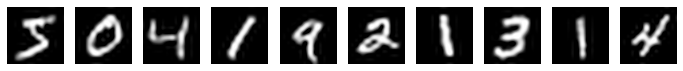

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline

def show_images(x):
    plt.figure(figsize=(12, 12 / 10 * (x.shape[0] // 10 + 1)))
    x = x.view(-1, digit_size, digit_size)
    for i in range(x.shape[0]):
        plt.subplot(x.shape[0] // 10 + 1, 10, i + 1)
        plt.imshow(x.data[i].numpy(), cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
        plt.axis('off')

show_images(train_data[:10][0])

In [17]:
n = 15

from scipy.stats import norm
import numpy as np

grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

def draw_manifold(generator):
    figure = np.zeros((digit_size * n, digit_size * n))
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])

            x_decoded = generator(z_sample)
            digit = x_decoded
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
    plt.axis('off')
    plt.show()

In [18]:
# valid_data[0][0].shape

### Функции и классы, описывающие модель и процесс её обучения

In [19]:
class Reshape(nn.Module):
    def __init__(self, *args):
        """
        Запоминает размерности, в которые при проходе
        вперед будут переводиться все объекты.
        Например,
            input = torch.zeros(100, 196)
            reshape_layer = Reshape(1, 14, 14)
            reshape_layer(input)
        возвращает тензор размерности (100, 1, 14, 14).
            input = torch.zeros(100, 1, 14, 14)
            reshape_layer = Reshape(-1)
            reshape_layer(input)
        наоборот вернет тензор размерности (100, 196).
        """
        super(type(self), self).__init__()
        self.dims = args

    def forward(self, input):
        """
        Возвращает тензор с измененными размерностями объектов.
        Вход: input, FloatTensor.
        Возвращаемое значение: FloatTensor.
        """
        return input.view(input.size(0), *self.dims)

In [20]:
class GAN(nn.Module):
    def __init__(self, d):
        """
        Инициализирует веса модели.
        Вход: d, int - размерность латентного пространства.
        Вход: D, int - размерность пространства объектов.
        """
        super(type(self), self).__init__()
        self.d = d
        # Можно пробовать другие архитектуры: как более сложные
        # сверточные, так и более простые, например, полносвязные.
        # Однако желательно обучить хотя бы одну сверточную модель.
        self.discriminator = nn.Sequential(
            Reshape(1, 14, 14),
            nn.Conv2d(1, 64, 3, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 32, 3, 2, 0, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 16, 3, 1, 0, bias=False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            Reshape(-1),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
        self.generator = nn.Sequential(
            Reshape(self.d, 1, 1),
            nn.ConvTranspose2d(self.d, 128, 4, 1, 0, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, 2, 1, 0, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 3, 2, 1, 1, bias=False),
            Reshape(-1),
            nn.Sigmoid()
        )

    def generate_noise(self, num_samples):
        """
        Генерирует сэмплы из априорного распределения на z.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Tensor, матрица размера num_samples x d.
        """
        z = torch.from_numpy(np.random.randn(num_samples, self.d)).float()
        if next(self.parameters()).is_cuda:
            z = z.cuda()
        return z

    def generate_samples(self, num_samples):
        """
        Генерирует сэмплы из индуцируемого моделью распределения на объекты x.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Tensor, матрица размера num_samples x D.
        """
        return self.generator(self.generate_noise(num_samples))

    def discriminator_loss(self, batch):
        """
        Вычисляет значение функции потерь дискриминатора на данном батче.
        Возвращаемая оценка должна быть дифференцируема по параметрам модели (!).
        Вход: batch, FloatTensor - матрица объектоа размера n x D.
        Возвращаемое значение: Tensor, скаляр - значение функции потерь
        дискриминатора на данном батче.
        """
        return - torch.mean(torch.log(self.discriminator(batch)) + torch.log(1 - self.discriminator(self.generate_samples(batch.shape[0])))) #1 - в тензор

    def generator_loss(self, batch_size):
        """
        Вычисляет значение функции потерь генератора на данном батче.
        Возвращаемая оценка должна быть дифференцируема по параметрам модели (!).
        Вход: batch, FloatTensor - матрица объектоа размера n x D.
        Возвращаемое значение: Tensor, скаляр - значение функции потерь
        генератора на данном батче.
        """
        return -torch.mean(torch.log(self.discriminator(self.generate_samples(batch_size))))

In [21]:
def log_mean_exp(mtx):
    """
    Возвращает логарифм среднего по каждому столбцу от экспоненты данной матрицы.
    Подсказка: не забывайте про вычислительную стабильность!
    Вход: mtx, Tensor - матрица размера n x k.
    Возвращаемое значение: Tensor, вектор длины n.
    """
    amax = torch.max(mtx, dim=0)[0]
    return amax + torch.log(torch.mean(torch.exp(mtx - amax), dim=0))

In [22]:
torch.range(-2, 2.1, 0.4)

In [48]:
def onvalid(x, g, sigm):
    return - x.shape[-1] * torch.log(2 * np.pi * sigm**2) / 2 + log_mean_exp(-((x.unsqueeze(0) - g.unsqueeze(1))**2).sum(dim = -1) / (2 * sigm**2)).mean()
def log_likelihood(generated_set, validation_set, test_set):
    """
    Возвращает оценку логарифма правдоподобия модели GAN методом
    Парзеновского окна со стандартным нормальным ядром.
    Подсказка: sigma должна настраиваться по валидационной выборке, а
    правдоподобие считаться по тестовой.
    Подсказка: вместо sigma можно настраивать log_sigma.
    Подсказка: для настойки sigma допустимо использовать как перебор по сетке,
    так и другие методы опимизации.
    Вход: generated_set - сэмплы из генеративной модели.
    Вход: validation_set - валидационная выборка.
    Вход: test_set - тестовая выборка.
    Возвращаемое значение: float (не Tensor!) - оценка логарифма правдоподобия.
    """
    b_s = 512
    
        
    sigma = torch.randn(10)
    losses = []
    opt = 0
    l_max = -99999
    for i, s in enumerate(sigma):
        l_0 = 0
        for j in validation_set:
            l_0 += onvalid(j, generated_set, s)
        l_0 = l_0/validation_set.shape[0]
        if len(losses) != 0 and l_0 >= l_max:
            opt = i
            l_max = l_0
        losses.append(l_0) 
        
    loss = 0
    for k in test_set:
        loss += onvalid(k, generated_set, sigma[opt])
    return loss / test_set.shape[0]

In [49]:
def generate_many_samples(model, num_samples, batch_size):
    size = 0
    res = []
    while size < num_samples:
        res.append(model.generate_samples(min(batch_size, num_samples - size)))
        size += batch_size
    return torch.cat(res, 0)

In [57]:
def train_model(model, num_epochs=100):
    """
    Обучает модель.
    Вход: model, Module - объект, модель.
    У этого объекта должна быть функция batch_loss от batch - FloatTensor и K - int,
    возвращающая скаляр Variable - функцию потерь на батче, которая должна быть
    оптимизирована.
    Вход: k, int - число итераций оптимизации дискриминатора на итерацию оптимизации
    генератора.
    Вход: batch_size, int.
    Вход: num_epochs, int.
    Вход: learning_rate, float.
    Возвращаемое значение: словарь с полями 'model' - обученная модель,
    'generator_losses' - список значений функции потерь генератора,
    'discriminator_losses' - список значений функции потерь дискриминатора.
    """
    if torch.cuda.is_available():
        model = model.cuda()
    model.train()

    # возможно, нужно подобрать другие параметры, чтобы модель обучилась
    if model.d == 2:
        batch_size = 64
    else:
        batch_size = 128
    learning_rate = 2e-4

    # возможно, нужно использовать другие методы оптимизации или параметры методов оптимизации,
    # чтобы модель обучилась
    gd_generator = optim.Adam(model.generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    gd_discriminator = optim.RMSprop(model.discriminator.parameters(), lr=learning_rate)

    dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    total_batches = len(dataloader)

    generator_losses = [0]
    discriminator_losses = [0]
    log_likelihoods = []

    generated_samples = generate_many_samples(model, 512, batch_size).detach()
    valid_samples = valid_data[np.random.choice(len(valid_data), 512, False)][0]
    valid_samples = valid_samples.to(next(model.parameters()).device)
    test_samples = test_data[np.random.choice(len(test_data), 512, False)][0]
    test_samples = test_samples.to(next(model.parameters()).device)
    ll = log_likelihood(generated_samples, valid_samples, test_samples)
    log_likelihoods.append(ll)
    print('Log-likelihood', ll, flush=True)

    for epoch in range(num_epochs):
        # show_images(model.generate_samples(5).cpu())
        for i, (batch, ) in enumerate(dataloader):
            if torch.cuda.is_available():
                batch = batch.cuda()
            # for j in ra/nge(5):
            gd_generator.zero_grad()
            gen_loss = model.generator_loss(batch_size) 
            gen_loss.backward()
            gd_generator.step()

            # torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

            gd_discriminator.zero_grad()
            discr_loss = model.discriminator_loss(batch)
            discr_loss.backward()
            gd_discriminator.step()

            # разрешается менять код этой функции для реализации
            # более сложных процедур обучения или ускорения обучения

            # не забудьте корректно сохранить статистику
            discriminator_losses.append(float(discr_loss))
            generator_losses.append(float(gen_loss))

            if (i + 1) % 100 == 0:
                print('\rEpoch:', epoch, 'G_loss:', generator_losses[-1],
                      'D_loss:', discriminator_losses[-1],
                      'Batch', i + 1, 'of', total_batches,
                      ' ' * 10, end='', flush=True)

        print(flush=True)
        generated_samples = generate_many_samples(model, 512, batch_size).detach()
        valid_samples = valid_data[np.random.choice(len(valid_data), 512, False)][0]
        valid_samples = valid_samples.to(next(model.parameters()).device)
        test_samples = test_data[np.random.choice(len(test_data), 512, False)][0]
        test_samples = test_samples.to(next(model.parameters()).device)
        ll = log_likelihood(generated_samples, valid_samples, test_samples)
        log_likelihoods.append(ll)
        print('Log-likelihood', ll, flush=True)

    return {
        'model': model.cpu(),
        'generator_losses': generator_losses,
        'discriminator_losses': discriminator_losses,
        'log_likelihoods': log_likelihoods
    }

### Обучение модели

In [58]:
# Подсказка: обучать GANs с скрытой размерностью 2 непросто,
# для этого требуется очень аккуратно подобрать хаки/процесс обучения/
# /архитектуру модели/инициализацию.
# Если не получается сразу, стоит обучить GANs с бОльшей скрытой размерностью,
# а затем вернуться к этой ячейке.
np.random.seed(42)
g2 = GAN(2)
# возможно, для обучения модели достаточно/требуется другое число эпох
%time gan_model_d2 = train_model(g2, num_epochs=30)

Log-likelihood tensor(-114.9461, device='cuda:0')
Epoch: 0 G_loss: 0.7945052981376648 D_loss: 1.266191005706787 Batch 900 of 938           
Log-likelihood tensor(-106.5891, device='cuda:0')
Epoch: 1 G_loss: 0.786552906036377 D_loss: 1.2220962047576904 Batch 900 of 938           
Log-likelihood tensor(-27.8185, device='cuda:0')
Epoch: 2 G_loss: 0.85040283203125 D_loss: 1.2500548362731934 Batch 900 of 938           
Log-likelihood tensor(-36.6006, device='cuda:0')
Epoch: 3 G_loss: 0.82806396484375 D_loss: 1.267716407775879 Batch 900 of 938           
Log-likelihood tensor(-4.5295, device='cuda:0')
Epoch: 4 G_loss: 1.0545727014541626 D_loss: 1.1646251678466797 Batch 900 of 938           
Log-likelihood tensor(-47.7722, device='cuda:0')
Epoch: 5 G_loss: 1.102597951889038 D_loss: 1.128603219985962 Batch 900 of 938           
Log-likelihood tensor(9.1462, device='cuda:0')
Epoch: 6 G_loss: 1.0112420320510864 D_loss: 0.9558155536651611 Batch 900 of 938           
Log-likelihood tensor(-1.2013,

In [52]:
g10 = GAN(10)
# возможно, для обучения модели достаточно/требуется другое число эпох
%time gan_model_d10 = train_model(g10, num_epochs=30)

Log-likelihood tensor(-150.4182, device='cuda:0')
Epoch: 0 G_loss: 0.7974002361297607 D_loss: 1.2451159954071045 Batch 900 of 938           
Log-likelihood tensor(-88.6857, device='cuda:0')
Epoch: 1 G_loss: 0.7452445030212402 D_loss: 1.3207257986068726 Batch 900 of 938           
Log-likelihood tensor(-10.7807, device='cuda:0')
Epoch: 2 G_loss: 0.7798319458961487 D_loss: 1.3184746503829956 Batch 900 of 938           
Log-likelihood tensor(35.2750, device='cuda:0')
Epoch: 3 G_loss: 0.7143778204917908 D_loss: 1.2938250303268433 Batch 900 of 938           
Log-likelihood tensor(-45.0539, device='cuda:0')
Epoch: 4 G_loss: 0.7265830636024475 D_loss: 1.3545310497283936 Batch 900 of 938           
Log-likelihood tensor(41.3700, device='cuda:0')
Epoch: 5 G_loss: 0.7707251906394958 D_loss: 1.3213682174682617 Batch 900 of 938           
Log-likelihood tensor(34.0380, device='cuda:0')
Epoch: 6 G_loss: 0.7955291271209717 D_loss: 1.3297150135040283 Batch 900 of 938           
Log-likelihood tensor(

In [63]:
g100 = GAN(100)
# возможно, для обучения модели достаточно/требуется другое число эпох
%time gan_model_d100 = train_model(g100, num_epochs=30)

Log-likelihood tensor(-134.4215, device='cuda:0')
Epoch: 0 G_loss: 0.7641123533248901 D_loss: 1.2572202682495117 Batch 400 of 469           
Log-likelihood tensor(-106.8379, device='cuda:0')
Epoch: 1 G_loss: 0.7732388973236084 D_loss: 1.261249303817749 Batch 400 of 469           
Log-likelihood tensor(6.8204, device='cuda:0')
Epoch: 2 G_loss: 0.8071334362030029 D_loss: 1.2334959506988525 Batch 400 of 469           
Log-likelihood tensor(-5.6386, device='cuda:0')
Epoch: 3 G_loss: 0.7980990409851074 D_loss: 1.2184277772903442 Batch 400 of 469           
Log-likelihood tensor(18.2668, device='cuda:0')
Epoch: 4 G_loss: 0.8244326710700989 D_loss: 1.132690668106079 Batch 400 of 469           
Log-likelihood tensor(21.9607, device='cuda:0')
Epoch: 5 G_loss: 0.8618853092193604 D_loss: 1.2315878868103027 Batch 400 of 469           
Log-likelihood tensor(-41.2579, device='cuda:0')
Epoch: 6 G_loss: 0.9191060066223145 D_loss: 1.1795032024383545 Batch 400 of 469           
Log-likelihood tensor(33.

### Анализ результатов

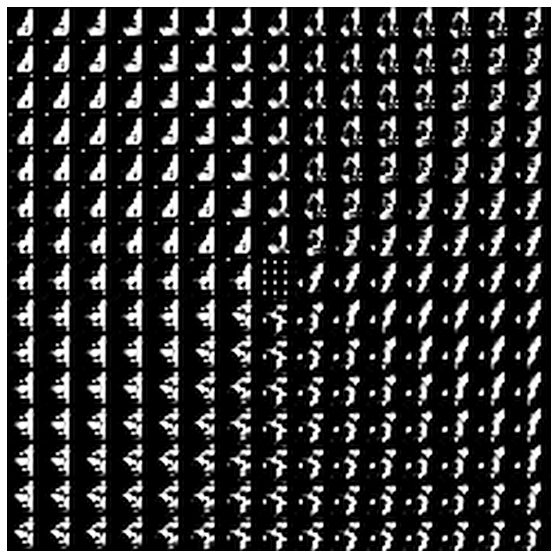

In [60]:
def draw_manifold_gan(model):
    generator = lambda z: model.generator(torch.from_numpy(z).float()).view(digit_size, digit_size).data.numpy()
    return draw_manifold(generator)


draw_manifold_gan(gan_model_d2['model'])

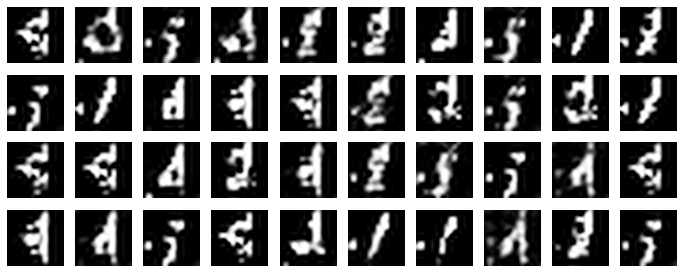

In [61]:
show_images(gan_model_d2['model'].generate_samples(40))

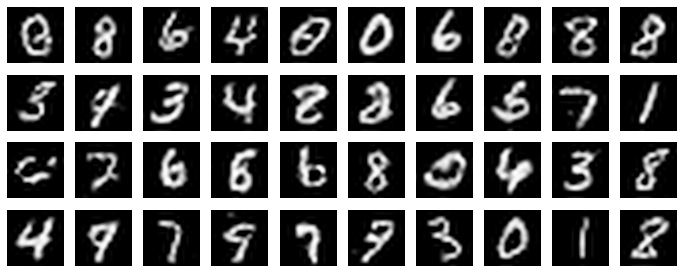

In [62]:
show_images(gan_model_d10['model'].generate_samples(40))

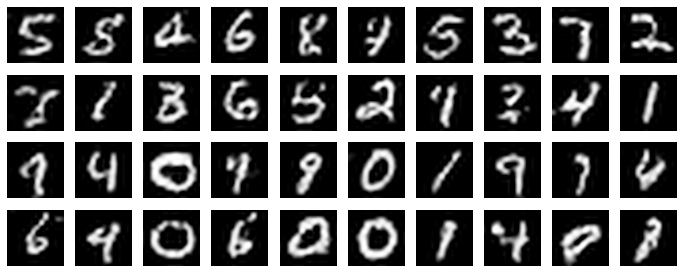

In [64]:
show_images(gan_model_d100['model'].generate_samples(40))

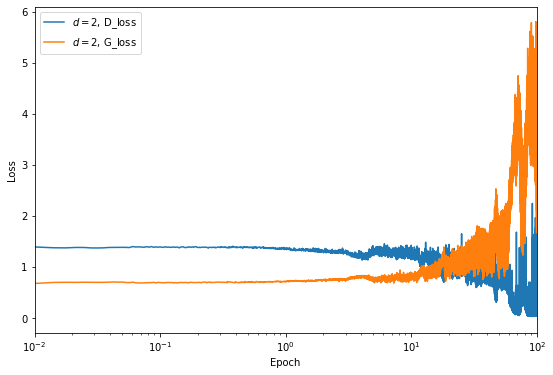

In [65]:
plt.figure(figsize=(9, 6))
for label, name, model in [
    ('$d = 2$, D_loss', 'discriminator_losses', gan_model_d2),
    ('$d = 2$, G_loss', 'generator_losses', gan_model_d2),
]:
    data = model[name]
    x_labels = (1 + np.arange(len(data))) / len(data) * 100
    plt.plot(x_labels, data, label=label)
plt.xlabel('Epoch')
plt.xlim(xmin=0.01, xmax=x_labels[-1])
plt.xscale('log')
plt.ylabel('Loss')
plt.legend()
pass

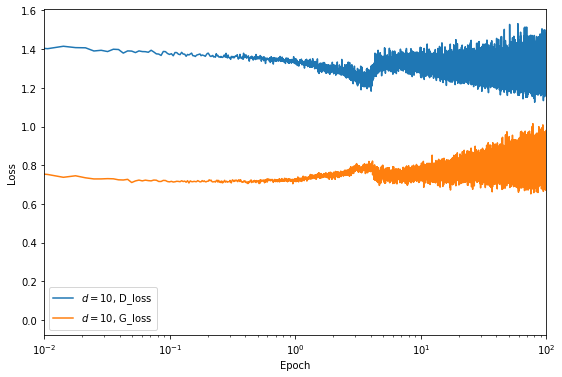

In [66]:
plt.figure(figsize=(9, 6))
for label, name, model in [
    ('$d = 10$, D_loss', 'discriminator_losses', gan_model_d10),
    ('$d = 10$, G_loss', 'generator_losses', gan_model_d10),
]:
    data = model[name]
    x_labels = (1 + np.arange(len(data))) / len(data) * 100
    plt.plot(x_labels, data, label=label)
plt.xlabel('Epoch')
plt.xlim(xmin=0.01, xmax=x_labels[-1])
plt.xscale('log')
plt.ylabel('Loss')
plt.legend()
pass

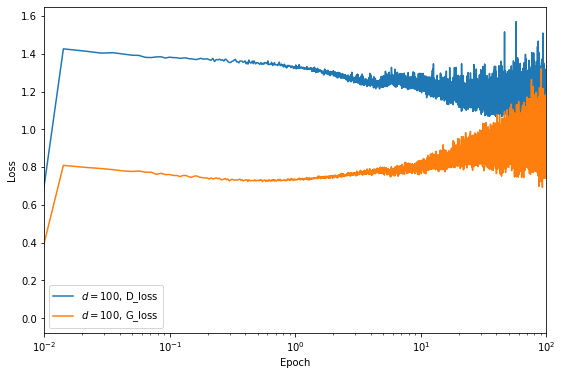

In [67]:
plt.figure(figsize=(9, 6))
for label, name, model in [
    ('$d = 100$, D_loss', 'discriminator_losses', gan_model_d100),
    ('$d = 100$, G_loss', 'generator_losses', gan_model_d100),
]:
    data = model[name]
    x_labels = (1 + np.arange(len(data))) / len(data) * 100
    plt.plot(x_labels, data, label=label)
plt.xlabel('Epoch')
plt.xlim(xmin=0.01, xmax=x_labels[-1])
plt.xscale('log')
plt.ylabel('Loss')
plt.legend()
pass

In [68]:
generated_samples = generate_many_samples(gan_model_d2['model'], 8192, 64).detach()
%time log_likelihood(generated_samples, valid_data.tensors[0], test_data.tensors[0])

CPU times: user 2min 14s, sys: 5.14 s, total: 2min 19s
Wall time: 2min 19s


tensor(-20.3434)

In [69]:
generated_samples = generate_many_samples(gan_model_d10['model'], 8192, 64).detach()
%time log_likelihood(generated_samples, valid_data.tensors[0], test_data.tensors[0])

CPU times: user 2min 31s, sys: 4.08 s, total: 2min 35s
Wall time: 2min 35s


tensor(88.0019)

In [70]:
generated_samples = generate_many_samples(gan_model_d100['model'], 8192, 64).detach()
%time log_likelihood(generated_samples, valid_data.tensors[0], test_data.tensors[0])

CPU times: user 2min 15s, sys: 3.65 s, total: 2min 19s
Wall time: 2min 19s


tensor(85.1342)

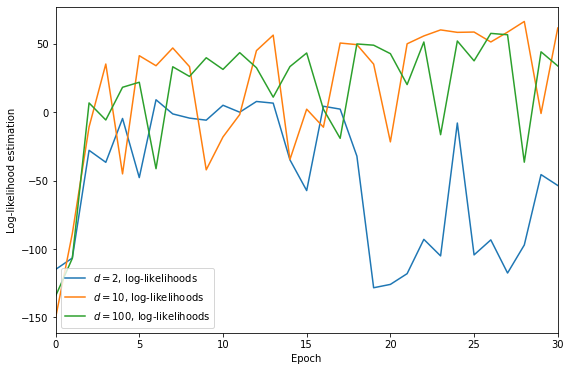

In [71]:
plt.figure(figsize=(9, 6))
for label, name, model in [
    ('$d = 2$, log-likelihoods', 'log_likelihoods', gan_model_d2),
    ('$d = 10$, log-likelihoods', 'log_likelihoods', gan_model_d10),
    ('$d = 100$, log-likelihoods', 'log_likelihoods', gan_model_d100),
]:
    data = model[name]
    x_labels = np.arange(len(data))
    plt.plot(x_labels, data, label=label)
plt.xlabel('Epoch')
plt.xlim(xmin=0.0, xmax=x_labels[-1])
plt.ylabel('Log-likelihood estimation')
plt.legend()
pass

## Выводы
Место для ваших выводов, наблюдений, гипотез.

После опытов были подобраны параметры для GANs с скрытой размерностью 2 и GANs с другой скрытой размерностью, так как параметры для первого не работали для остальных, и наоборот.

Сложность подбора параметров для GANs с скрытой размерностью 2 могу попробовать объяснить сложностью представить взаимнооднозначносное соответствие двумерного вектора с вектором изображения размерности 196. Что для модели малоразличны результаты отображения из-за малого размера входного вектора. 

log-likelihood на каждой эпохе получается сильно различными и не просматривается тенденция. Могу взять на себя смелось предположить причину, что из-за того что в этой функции log-likelihood по сути есть log_mean_exp с параметрами $\alpha_{j}$ равными длине по метрике Евклида разности векторов $x_{i}$ и $G(z_{j})$, то даже при удачно подобранных параметрах для генератора $x_{i}$ и $G(z_{j})$ могут означать разные числа изображенные на картинках, что означает большое значение длины разности, что в свою очередь означает малое значение результата выполнения функции log-likelihood. 